# Exercise 2 - Solutions

As always, first import the libraries which we need throughout the exercise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from rdatasets import data

### 1 The shape of the errors

#### a) Linear dependence on x

Given that the exercise asks us to simulate data with different bounds for the uniform error term `u`, it is a good idea to wrap the simulation into a function. In this case the input arguments will themselves be functions. This also makes it easier to play around with other specifications. 

In [2]:
def simulate_a(a, b):
    """
    This function simulates data according to y = 2 + 3x + u with uniform errors. 
    
    Parameters
    ----------
        a : function for the lower bound of the uniform random variable
        b : function for the upper bound of the uniform random variable
        
    Returns
    -------
        x : the x values
        y : the y values
    """
    
    # set a seed for reproducability
    rng = np.random.default_rng(seed = 313)

    # generate x on a [0, 1] interval
    x = np.linspace(0, 1, num = 100)

    # draw 100 draws of a uniform random variable
    u = rng.uniform(a(x), b(x), 100)

    # compute y
    y = 2 + 3 * x + u
    
    return x, y

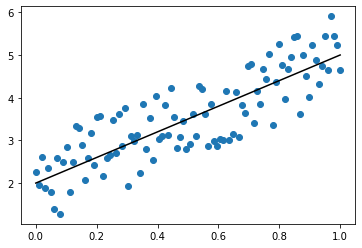

In [3]:
# call the function 
x, y = simulate_a(lambda x: -1, lambda x: 1)

# run a linear regression
res_ls = smf.ols("y ~ x", data = pd.DataFrame([y, x]).T).fit()

# plot a scatterplot 
plt.scatter(x, y)
plt.plot(x, 2 + 3 * x, color = "black")
plt.show()

Now use the alternative specification for the bounds of `u`.

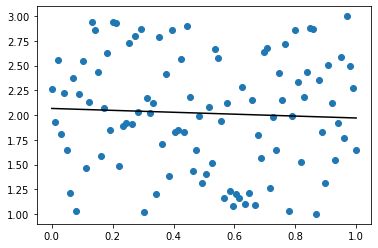

In [4]:
# call the function 
x, y = simulate_a(lambda x: -1-3*x, lambda x: 1-3*x)

# run a linear regression
res_ls = smf.ols("y ~ x", data = pd.DataFrame([y, x]).T).fit()

# plot a scatterplot & regression line
plt.scatter(x, y)
plt.plot(x, res_ls.params[0] + x * res_ls.params[1], color = "black")
plt.show()

#### b) Is any line possible?

To allow for other functional forms of `u`, we can adjust our simulation from above and allow for an additional function as input, which determines how `u` depends on `x`.

In [5]:
def simulate_b(a, b, v):
    """
    This function simulates data according to y = 2 + 3x + u with uniform errors. 
    
    Parameters
    ----------
        a : function for the lower bound of the uniform random variable
        b : function for the upper bound of the uniform random variable
        v : function for the structural relationship between x and u
        
    Returns
    -------
        x : the x values
        y : the y values
    """
    
    # set a seed for reproducability
    rng = np.random.default_rng(seed = 313)

    # generate x on a [0, 1] interval
    x = np.linspace(0, 1, num = 100)

    # draw 100 draws of a uniform random variable allowing for a dependence on x
    u = v(x) + rng.uniform(a(x), b(x), 100)

    # compute y
    y = 2 + 3 * x + u
    
    return x, y

In the exercise, we were specifically told not to adjust $y = 2 + 3x + u$. Rather, we were given the instruction to adjust the functional form of `u`. To achieve a regression line close to $100-\pi^2x$ we thus have to define $u = -2 - 3x +100 -\pi^2x + \nu$, where $\nu$ is a uniform random variable on the interval $[-1,1]$.

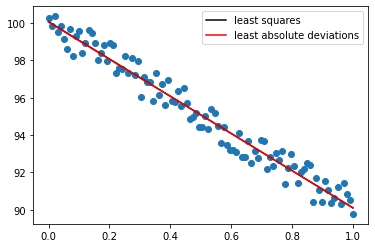

In [6]:
# call the function 
x, y = simulate_b(lambda x: -1, lambda x: 1, lambda x: -2 - 3*x + 100 -np.pi**2*x)

# run a linear regression
res_ls = smf.ols("y ~ x", data = pd.DataFrame([y, x]).T).fit()

# run a least absolute deviations (quantile) regression
res_lad = smf.quantreg("y ~ x", data = pd.DataFrame([y, x]).T).fit(q = 0.5)

# plot a scatterplot & regression line
plt.scatter(x, y)
plt.plot(x, res_ls.params[0] + x * res_ls.params[1], color = "black", label="least squares")
plt.plot(x, res_lad.params[0] + x * res_lad.params[1], color = "red", label="least absolute deviations")
plt.legend()
plt.show()

Finally, let us confirm that the regression parameters are indeed close to $100$ and $-2\pi x$, respectively. 

In [7]:
# print the parameter estimates
print('Least Squares:\n' + str(res_ls.params))
print('\nLeast Absolute Deviations:\n' + str(res_lad.params))
print('\n -π^2:\n' + str(-np.pi**2))

Least Squares:
Intercept    100.066674
x             -9.965847
dtype: float64

Least Absolute Deviations:
Intercept    100.044628
x             -9.933865
dtype: float64

 -π^2:
-9.869604401089358


In [8]:
mod = smf.quantreg("y ~ x", data = pd.DataFrame([y, x]).T)
res_lad = mod.fit(q = 0.5)

#### c) Large errors in the linear model

We can simply recycle our simulation from part "a)" to answer this question:

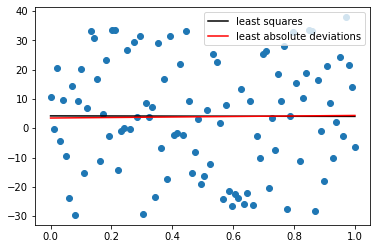

In [9]:
# call the function 
x, y = simulate_a(lambda x: -33, lambda x: 33)

# run a linear regression
res_ls = smf.ols("y ~ x", data = pd.DataFrame([y, x]).T).fit()
res_ls.params

# run a least absolute deviations (quantile) regression
res_lad = smf.quantreg("y ~ x", data = pd.DataFrame([y, x]).T).fit(q = 0.5)

# plot a scatterplot & regression line
plt.scatter(x, y)
plt.plot(x, res_ls.params[0] + x * res_ls.params[1], color = "black", label="least squares")
plt.plot(x, res_lad.params[0] + x * res_lad.params[1], color = "red", label="least absolute deviations")
plt.legend()
plt.show()

In [10]:
# print the parameter estimates
print('Least Squares:\n' + str(res_ls.params))
print('\nLeast Absolute Deviations:\n' + str(res_lad.params))

Least Squares:
Intercept    4.200230
x           -0.175999
dtype: float64

Least Absolute Deviations:
Intercept    3.472592
x            0.879615
dtype: float64


As we can see, the coefficient estimates are very imprecise in this small sample. Recall that the true intercept is $2$ and that the true $\beta$-coefficient is equal to $3$. We cam also see, however, that LAD is more robust to large errors than linear regression.

(As an additional exercise, investigate what happens, if you increase the sample size.)

#### d) Heteroskedasticity on the linear model

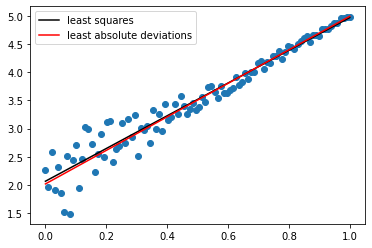

In [11]:
# call the function 
x, y = simulate_a(lambda x: -np.exp(-3*x), lambda x: np.exp(-3*x))

# run a linear regression
res_ls = smf.ols("y ~ x", data = pd.DataFrame([y, x]).T).fit()
res_ls.params

# run a least absolute deviations (quantile) regression
res_lad = smf.quantreg("y ~ x", data = pd.DataFrame([y, x]).T).fit(q = 0.5)

# plot a scatterplot & regression line
plt.scatter(x, y)
plt.plot(x, res_ls.params[0] + x * res_ls.params[1], color = "black", label="least squares")
plt.plot(x, res_lad.params[0] + x * res_lad.params[1], color = "red", label="least absolute deviations")
plt.legend()
plt.show()

In [12]:
# print the parameter estimates
print('Least Squares:\n' + str(res_ls.params))
print('\nLeast Absolute Deviations:\n' + str(res_lad.params))

Least Squares:
Intercept    2.065822
x            2.905068
dtype: float64

Least Absolute Deviations:
Intercept    2.017984
x            2.976457
dtype: float64


As you might have seen directly from $e^{-3x}$ or alternatively in the scatterplot, the variance of the residuals decreases in $x$ for negative and positive draws. The parameter estimates are rather unaffected, somewhat more precise for LDA though.   

#### e) Heteroskedasticity in the non-linear model

We can quickly adjust out simulation from "a)" to accomplish this task. Alternatively, we can set up our function in a way that we can pass the functional form of y directly as an input argument (see below). Feel free to play around and try different specifications. 

In [13]:
def simulate_e(a, b, g):
    """
    This function simulates data according to y = g(x) + u with uniform errors. 
    
    Parameters
    ----------
        a : function for the lower bound of the uniform random variable
        b : function for the upper bound of the uniform random variable
        g : the functional from of y, e.g. y = np.exp(3*x**2) + u
        
    Returns
    -------
        x : the x values
        y : the y values
    """
    
    # set a seed for reproducability
    rng = np.random.default_rng(seed = 313)

    # generate x on a [0, 1] interval
    x = np.linspace(0, 1, num = 100)

    # draw 100 draws of a uniform random variable
    u = rng.uniform(a(x), b(x), 100)

    # compute y
    y = g(x) + u
    
    return x, y

##### using the `u` in exercise d)

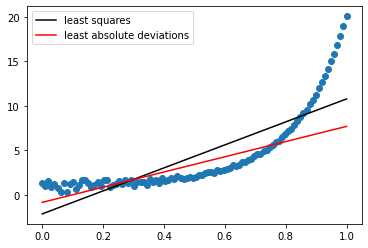

In [14]:
# call the function 
x, y = simulate_e(lambda x: -np.exp(-3*x), lambda x: np.exp(-3*x), lambda x: np.exp(3*x**2))

# run a linear regression
res_ls = smf.ols("y ~ x", data = pd.DataFrame([y, x]).T).fit()
res_ls.params

# run a least absolute deviations (quantile) regression
res_lad = smf.quantreg("y ~ x", data = pd.DataFrame([y, x]).T).fit(q = 0.5)

# plot a scatterplot & regression line
plt.scatter(x, y)
plt.plot(x, res_ls.params[0] + x * res_ls.params[1], color = "black", label="least squares")
plt.plot(x, res_lad.params[0] + x * res_lad.params[1], color = "red", label="least absolute deviations")
plt.legend()
plt.show()

In [15]:
# print the parameter estimates
print('Least Squares:\n' + str(res_ls.params))
print('\nLeast Absolute Deviations:\n' + str(res_lad.params))

Least Squares:
Intercept    -2.161164
x            12.931903
dtype: float64

Least Absolute Deviations:
Intercept   -0.866645
x            8.549591
dtype: float64


##### using $u\sim U(-1,1)$

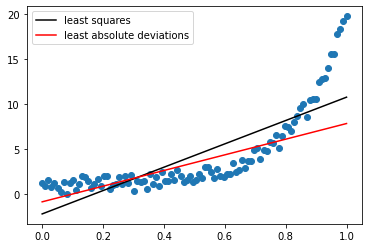

In [16]:
# call the function 
x, y = simulate_e(lambda x: -1, lambda x: 1, lambda x: np.exp(3*x**2))

# run a linear regression
res_ls = smf.ols("y ~ x", data = pd.DataFrame([y, x]).T).fit()

# run a least absolute deviations (quantile) regression
res_lad = smf.quantreg("y ~ x", data = pd.DataFrame([y, x]).T).fit(q = 0.5)

# plot a scatterplot & regression line
plt.scatter(x, y)
plt.plot(x, res_ls.params[0] + x * res_ls.params[1], color = "black", label="least squares")
plt.plot(x, res_lad.params[0] + x * res_lad.params[1], color = "red", label="least absolute deviations")
plt.legend()
plt.show()

In [17]:
# print the parameter estimates
print('Least Squares:\n' + str(res_ls.params))
print('\nLeast Absolute Deviations:\n' + str(res_lad.params))

Least Squares:
Intercept    -2.160312
x            12.930593
dtype: float64

Least Absolute Deviations:
Intercept   -0.820956
x            8.672398
dtype: float64


The results remain largely unaffected, but wrong. Our model is clearly misspecified, given that the true relationship is non-linear, but we estimate a linear relationship. 

### 2 An explorative plotting function

In [18]:
def plotreg(y, x, lda = True):
    """ A scatterplot of y vs x, with the the least squares regression lines imposed. If lad is True, then
    the least absolute deviation line is also added. 
    
    Parameters
    ----------
    y   : the y data
    x   : the x data
    lda : binary indicator. If lda == 1, the LDA regression line will also be plotted
    
    """
    
    # run a least squares regression
    res_ls = smf.ols("y ~ x", data = pd.DataFrame([y, x]).T).fit()
    res_ls.params
    
    # plot the scatterplot
    plt.scatter(x, y)
    
    # plot the least squares regression 
    plt.plot(x, res_ls.params[0] + x * res_ls.params[1], color = "black", label="least squares")
    
    # if statement for switching LDA estimation on or off
    if lda == 1:
        # run a least absolute deviations (quantile) regression
        res_lad = smf.quantreg("y ~ x", data = pd.DataFrame([y, x]).T).fit(q = 0.5)
        
        # plot the least absolute deviations regression
        plt.plot(x, res_lad.params[0] + x * res_lad.params[1], color = "red", label="least absolute deviations")
    
    # plot the chart
    plt.legend()
    plt.show()

We can now use this function to explore various kinds of functional relationships. Notice that we do not have the additive residuals as before. To use our functions from before, I simply set $u\sim U(0,0)$ which results in all draws being equal to $0$. Thus, no residual is added. The multiplicative $u$ can be added directly in the functional form for $y$. 

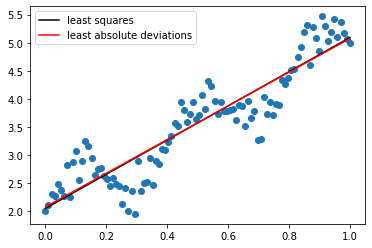

In [19]:
# simulate data
rng = np.random.default_rng(seed = 313)
x, y = simulate_e(lambda x: 0, lambda x: 0, lambda x: 2 + 3*x + np.sin(x*5*np.pi)*rng.uniform(0,1,100))

# plot the results
plotreg(y, x, 1)

### 3 Minimizing loss functions

#### a) Implementation
For ease of use, let's built a class:

In [20]:
class Loss_functions:
    
    """
    This class implements all the loss functions form class.
    
    Parameters
    __________
    x : x values
    y : y values
    
    """
    
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def AVL(self):
        """
        This function computes the absolute value loss
        """
        # unpack the data
        x, y = self.x, self.y
        
        # return the absolute value loss
        return np.abs(x - y)
    
    def QL(self):
        """
        This function computes the quadratic loss
        """
        # unpack the data
        x, y = self.x, self.y
        
        # return the quadratic loss
        return (x-y)**2
    
    def Linex(self):
        """
        This function computes Linex loss
        """
        # unpack the data
        x, y = self.x, self.y
        
        # return the linex loss
        return np.exp(y-x)-(y-x)-1
        
    def Welsch(self):
        """
        This function computes Welsch loss
        """
        # unpack the data
        x, y = self.x, self.y
        
        # return the Welsch loss
        return 1-np.exp(-0.5*(x-y)**2)
    
    def Huber(self):
        """
        This function computes Huber loss
        """
        # unpack the data
        x, y = self.x, self.y
        
        # return the Huber loss
        return (np.abs(x-y)-0.5)*(np.abs(x-y)>1) + 0.5*(x-y)**2 * (np.abs(x-y)<=1)
        

#### b) Plotting 

With our class in place, we can now easily plot all the functions for the same data.

In [21]:
# generate x
x = np.linspace(-4, 4, num = 1000)

# initialize the class
LFs = Loss_functions(x,0)

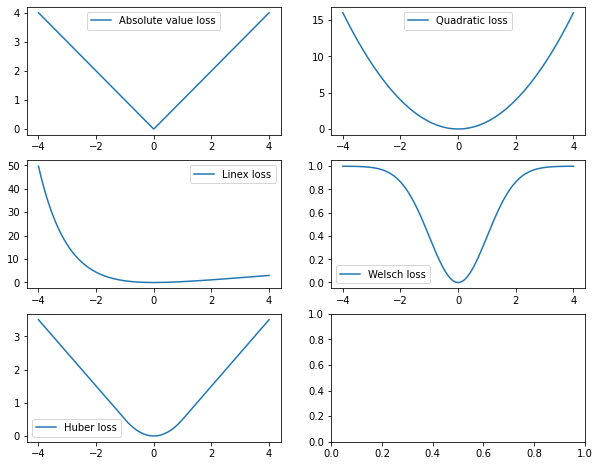

In [22]:
# compute all loss functions
AVL = LFs.AVL()
QL = LFs.QL()
Linex = LFs.Linex()
Welsch = LFs.Welsch()
Huber = LFs.Huber()

# set a figure size default
plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size

# create subplots
fig, ax = plt.subplots(3,2)

# plot the absolute value loss
ax[0,0].plot(x, AVL, label="Absolute value loss")
ax[0,0].legend()

# plot the quadratic loss
ax[0,1].plot(x, QL, label="Quadratic loss")
ax[0,1].legend()

# plot the linex loss
ax[1,0].plot(x, Linex, label="Linex loss")
ax[1,0].legend()

# plot the welsch loss
ax[1,1].plot(x, Welsch, label="Welsch loss")
ax[1,1].legend()

# plot the huber loss
ax[2,0].plot(x, Huber, label="Huber loss")
ax[2,0].legend()

# show the plots
plt.show()


#### c) Verification

Let us verify the claims in turn. Note that we only explore a tiny part of the functions support here, which does not qualify as a full mathematical proof.

In [23]:
# test whether the functions' output is >=0 
print('AVL >=0: ' + str((AVL>=0).all()))
print('QL >=0: ' + str((QL>=0).all()))
print('Linex >=0: ' + str((Linex>=0).all()))
print('Welsch >=0: ' + str((Welsch>=0).all()))
print('Huber >=0: ' + str((Huber>=0).all()))

## test whether x=y results in loss = 0
LFs = Loss_functions(x[0],x[0])

# compute all loss functions
AVL = LFs.AVL()
QL = LFs.QL()
Linex = LFs.Linex()
Welsch = LFs.Welsch()
Huber = LFs.Huber()

print('\nAVL = 0 for x=y: ' + str((AVL==0)))
print('QL = 0 for x=y: ' + str((QL==0)))
print('Linex = 0 for x=y: ' + str((Linex==0)))
print('Welsch = 0 for x=y: ' + str((Welsch==0)))
print('Huber = 0 for x=y: ' + str((Huber==0)))


AVL >=0: True
QL >=0: True
Linex >=0: True
Welsch >=0: True
Huber >=0: True

AVL = 0 for x=y: True
QL = 0 for x=y: True
Linex = 0 for x=y: True
Welsch = 0 for x=y: True
Huber = 0 for x=y: True


We have thus verified the claim for our support region.

#### d) Interpreting

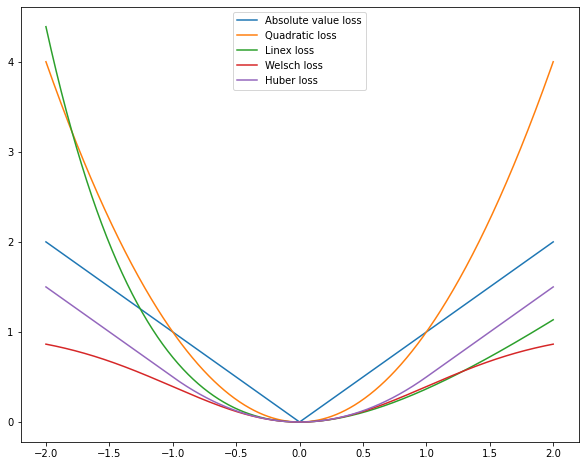

In [24]:
# generate x
x = np.linspace(-2, 2, num = 1000)

# initialize the class
LFs = Loss_functions(x,0)

# compute all loss functions
AVL = LFs.AVL()
QL = LFs.QL()
Linex = LFs.Linex()
Welsch = LFs.Welsch()
Huber = LFs.Huber()

# plot the absolute value loss
plt.plot(x, AVL, label="Absolute value loss")
plt.plot(x, QL, label="Quadratic loss")
plt.plot(x, Linex, label="Linex loss")
plt.plot(x, Welsch, label="Welsch loss")
plt.plot(x, Huber, label="Huber loss")
plt.legend()

# show the plots
plt.show()

Here are some interpretations:
* Linex loss penalizes large negative distances more strongly than any other loss function, but penalizes large positive distances less strongly than most other loss functions.
* Welsch loss penalizes large positive as well as negative distances the least.
* quadratic loss penalizes large positive distances the most. 

...

### 4 An example

#### a) 

In [27]:
# load the data
df = data("boot", "ducks")
df.head()


,plumage,behaviour
0,7,3
1,13,10
2,14,11
3,6,5
4,14,15


#### b)

In [29]:
# run a linear regression
res_ls = smf.ols("plumage ~ behaviour", data = df).fit()

# print the parameters
res_ls.params

Intercept    2.729911
behaviour    0.809710
dtype: float64

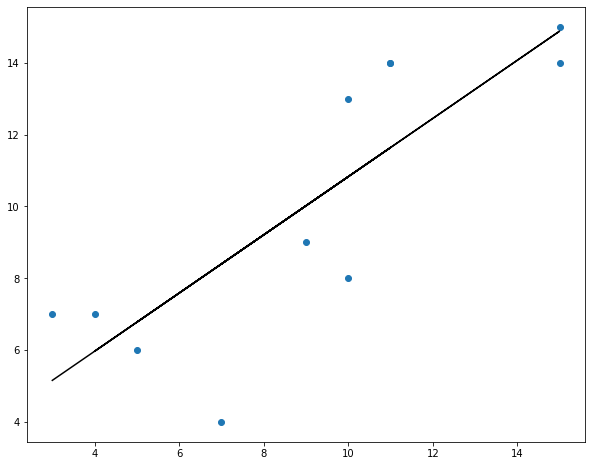

In [31]:
# plot the data together with the regression line
plt.scatter(df.behaviour, df.plumage)
plt.plot(df.behaviour, res_ls.params[0] + df.behaviour * res_ls.params[1], color = "black", label="least squares")
plt.show()

The relationship looks somewhat linear. We have to keep in mind though that this is a very small sample. 

###  5 The least squares solutions

#### a) 

$$
\frac{\partial f(a,b)}{\partial a} = -2 \sum_{i=1}^n  (y_i - a -bx_i)
$$

setting the derivative equal to zero yields:

$$
0 = -2 \sum_{i=1}^n  (y_i - a -bx_i) \\
a = \frac{1}{n}\sum_{i=1}^n y_i - b\frac{1}{n}\sum_{i=1}^n x_i \\
a = \bar{y}-b\bar{x}
$$

#### b) 

$$
\frac{\partial f(a,b)}{\partial b} = -2 \sum_{i=1}^n  (y_i - a -bx_i)x_i
$$

setting the derivative equal to zero yields and replacing $a$ with $\hat{a}$:


$$
0 = -2 \sum_{i=1}^n  (y_i - \hat{a} -bx_i)x_i \\
0 = \sum_{i=1}^n  (y_i - \hat{a} -bx_i)x_i \\
0 = \sum_{i=1}^n  (y_i - \bar{y} + b\bar{x} -bx_i)x_i \\
0 = \sum_{i=1}^n  (y_ix_i - \bar{y}x_i + b\bar{x}x_i -bx_i^2) \\
b = \frac{\sum_{i=1}^n  (y_ix_i - \bar{y}x_i)}{ \sum_{i=1}^n (x_i^2 - \bar{x}x_i)}
$$
